# Polymer Brush Simulation Analysis Notebook

In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=True;
    $('div.input').show()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Hide Code"></form>''')

In [ ]:
%matplotlib widget
# %matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib import rcParams
import math
import sys
import pickle
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.CRITICAL)
import pb_sims as pb

In [4]:
dN = 3
dM = 4
dX = 0
dPD = 2
dV = 5
dRing = True
dLinear = True
dLoop = True
dBB = False
dSI = False
dLog = True
damin = -2
damax = 3
dkmin = -3
dkmax =3

In [5]:
scaling  = 1.4
figx = 6 * scaling
figy = 4 * scaling
font_size = 10 * scaling
rcParams['axes.labelsize'] = font_size
rcParams['xtick.labelsize'] = font_size
rcParams['ytick.labelsize'] = font_size
rcParams['legend.fontsize'] = font_size
rcParams['font.size'] = font_size
rcParams['figure.figsize'] = figx, figy
rcParams['toolbar'] = 'None'
box_layout = widgets.Layout(display='flex',flex_flow='row wrap',align_items='stretch',)

In [6]:
print('Hello')
print(sys.version)

Hello
3.12.9 (main, Nov 10 2011, 15:00:00) [GCC 14.2.0]


In [7]:
data_f = 'data'
T_info_f = os.path.join(data_f,'T_info')
with open(T_info_f,'rb') as f:
    unpickler = pickle.Unpickler(f)
    T_info = unpickler.load()


T_Names = [T_info[i][0].split()[0] for i in range(len(T_info))]
T_Ndirs = T_info[0][1]
T_Mdirs = T_info[0][2]
T_Xdirs = T_info[0][3]
T_PDdirs = T_info[0][4]
T_Vdirs = T_info[0][5]

In [8]:
print('Brush Topologies and Parameter Values')
print('--------------------------------------')
for i in T_info:
    for j in i:
        print(j, end = '\n')
    print('',sep='\n')

Brush Topologies and Parameter Values
--------------------------------------
Cyclic Brushes
['N=30', 'N=40', 'N=50', 'N=60']
['M=18', 'M=38', 'M=44', 'M=58', 'M=100', 'M=158', 'M=208']
['X=0']
['D=10', 'D=20', 'D=30', 'D=40', 'D=50', 'D=70']
['V=0.0010000000000000000208', 'V=0.0030000000000000000625', 'V=0.010000000000000000208', 'V=0.02999999999999999889', 'V=0.10000000000000000555', 'V=0.2999999999999999889', 'V=1']

Linear Brushes
['N=30', 'N=40', 'N=50', 'N=60']
['M=18', 'M=38', 'M=44', 'M=58', 'M=100', 'M=158', 'M=208']
['X=0']
['D=10', 'D=20', 'D=30', 'D=40', 'D=50', 'D=70']
['V=0.0010000000000000000208', 'V=0.0030000000000000000625', 'V=0.010000000000000000208', 'V=0.02999999999999999889', 'V=0.10000000000000000555', 'V=0.2999999999999999889', 'V=1']

Loop Brushes
['N=30', 'N=40', 'N=50', 'N=60']
['M=18', 'M=38', 'M=44', 'M=58', 'M=100', 'M=158', 'M=208']
['X=0']
['D=10', 'D=20', 'D=30', 'D=40', 'D=50', 'D=70']
['V=0.0010000000000000000208', 'V=0.0030000000000000000625', 'V=0.01

In [9]:
def make_exclude_list(Ring,Linear,Loop,BB):
    exclude_list = []
    if not Ring:
        exclude_list.append(0)
    if not Linear:
        exclude_list.append(1)
    if not Loop:
        exclude_list.append(2)
    if not BB:
        exclude_list.append(3)
    return(exclude_list)

def make_handles(Ring,Linear,Loop,BB):
    h_full = [plt.plot([],[], "k-")[0],plt.plot([],[], "k--")[0],plt.plot([],[], "k-.")[0],plt.plot([],[], "k:")[0] ]
    count = 0
    for Topo in [Ring,Linear,Loop,BB]:
        if Topo:
            count += 1
    h = h_full[:count]
    return h


def make_labels(Ring,Linear,Loop,BB):
    labels = []
    if Ring:
        labels.append('Cyclic')
    if Linear:
        labels.append('Linear')
    if Loop:
        labels.append('Loop')
    if BB:
        labels.append('BB')
    return labels


In [10]:
def t_u(mass, length, energy):
    return math.sqrt((mass*(length)**2)/(energy))
def v_u(mass, length, energy):
    t = t_u(mass,length,energy)
    return (length/t)
def f_u(length, energy):
    return(energy/length)
def T_u(energy):
    return(energy/kB)
def p_u(length, energy):
    return energy/(length**3)
def d_u(mass,length):
    return(mass/(length**3))
def area_u(length):
    return(areaLJ * (length)**2)

In [11]:
m_bead = 44.05     # in Da (g/mole)
melt_density = 1100   # in kg/m3
non_binding_energy = 1.38  # in KJ/mol 
Na = 6.0221409e+23
kB = 1.38064852e-23 # in m2 kg s-2 K-1
Lx = 30
Ly = 25
areaLJ = Lx *Ly

r_bead = ((3/(4 * math.pi))* ((m_bead * 0.001)/((Na)*(melt_density))))**(1/3)
massSI = (m_bead/1000) / Na
sigmaSI = 2 * r_bead
print(massSI)
print(sigmaSI)
epsSI = (non_binding_energy * 1000 / Na) #in J
print(epsSI)

m_SI = massSI
L_SI = sigmaSI
E_SI = epsSI
a_SI = L_SI**2
N_SI = m_bead/1000
G_SI = 1/a_SI


L_NM = L_SI * 1e9
a_NM = L_NM**2
G_NM = 1/a_NM

areaSI = areaLJ * a_SI
areaNM = areaLJ * a_NM


t_SI = t_u(massSI,sigmaSI,epsSI)
v_SI = v_u(massSI,sigmaSI,epsSI)
f_SI = f_u(sigmaSI,epsSI)
T_SI = T_u(epsSI)
p_SI = p_u(sigmaSI,epsSI)
d_SI = d_u(massSI,sigmaSI)
U_SI = p_SI * t_SI

p_MPa = p_SI * 1e-6

T_Gdirs = [r'$\sigma_g ={0:.3f}$'.format(int(M[2:])/areaLJ) for M in T_Mdirs]


7.314674420852558e-26
5.026525586679885e-10
2.291543859427135e-21


In [12]:
print(areaLJ)

750


In [13]:
# Read the data
HvRho_f = os.path.join(data_f,'RhovH_data')
PvD_f = os.path.join(data_f,'PvD_data')
OvD_f = os.path.join(data_f,'OvD_data')
NMFHvD_f = os.path.join(data_f,'NMFHvD_data')
FMFHvD_f = os.path.join(data_f,'FMFHvD_data')
MDvD_f = os.path.join(data_f,'MDvD_data')
RvS_f = os.path.join(data_f,'RvS_data')
PvS_f = os.path.join(data_f,'PvS_data')
FvS_f = os.path.join(data_f,'FvS_data')
FvS_m_f = os.path.join(data_f,'FvS_m_data')
FvW_f = os.path.join(data_f,'FvW_data')
FvW_m_f = os.path.join(data_f,'FvW_m_data')
FvM = os.path.join(data_f,'FvM_data')
NvM_f = os.path.join(data_f,'NvM_data')
Dv_f = os.path.join(data_f,'Dv_data')
OvDs_f = os.path.join(data_f,'OvDs_data')
NMFHvDs_f = os.path.join(data_f,'NMFHvDs_data')
FMFHvDs_f = os.path.join(data_f,'FMFHvDs_data')
MDvV_f = os.path.join(data_f,'MDvV_data')
eDPS_f = os.path.join(data_f,'eDPS_data')
sDPS_f = os.path.join(data_f,'sDPS_data')
cDPS_f = os.path.join(data_f,'cDPS_data')
TDV_f = os.path.join(data_f,'TDV_data')
VvW_f = os.path.join(data_f,'VvW_data')

if (os.path.isfile(HvRho_f) == True):
    with open(eDPS_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        eDPS = unpickler.load()
    with open(cDPS_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        cDPS0 = unpickler.load()
    with open(TDV_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        TDV = unpickler.load()
    with open(HvRho_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        HvRho = unpickler.load()
    with open(sDPS_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        sDPS = unpickler.load()
    with open(PvD_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        PvD0 = unpickler.load()
    with open(OvD_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        OvD = unpickler.load()
    with open(NMFHvD_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        NMFHvD = unpickler.load()
    with open(FMFHvD_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        FMFHvD = unpickler.load()
    with open(MDvD_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        MDvD = unpickler.load()
    with open(RvS_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        RvS = unpickler.load()
    with open(PvS_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        PvS = unpickler.load()
    with open(FvS_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        FvS = unpickler.load()
    with open(NvM_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        NvM = unpickler.load()
    with open(Dv_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        Dv0 = unpickler.load()
    with open(OvDs_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        OvDs = unpickler.load()
    with open(NMFHvDs_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        NMFHvDs = unpickler.load()
    with open(FMFHvDs_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        FMFHvDs = unpickler.load()
    with open(MDvV_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        MDvV = unpickler.load()
    with open(VvW_f,'rb') as f:
        unpickler = pickle.Unpickler(f)
        VvW = unpickler.load()
        
        


In [14]:
print(eDPS[0].shape)
print(len(eDPS))
print(cDPS0[0].shape)
print(sDPS[0].shape)

(4, 7, 1, 1, 1, 2, 1000)
4
(4, 7, 1, 6, 8, 1000)
(4, 7, 1, 6, 7, 8, 1000)


In [15]:
print(PvD0[0].shape)
PvD = [np.ma.expand_dims(PvD0[i],axis=-3) for i in range(len(T_info))]
T_Vdirs0 = T_Vdirs
T_Vdirs = ['V=0'] + T_Vdirs
T_Vdirs = [Vdir[:8] if (len(Vdir)>8) else Vdir for Vdir in T_Vdirs]

HvRho2 = [HvRho[i] for i in range(len(HvRho))]

# for N in range(HvRho2[0].shape[0]):
#     for M in range(HvRho2[0].shape[1]): 
#         for X in range(HvRho2[0].shape[2]):
#             HvRho2[0][N,M,X,0,0,0,0] = HvRho2[0][N,M,X,0,0,0,0]*1
#             X += 1
#         M += 1
#     N +=1
HvRho = []
for i in range(len(T_info)):
    HvRhosp = np.broadcast_to(HvRho2[i],NvM[i].shape)
    HvRhocp = np.ma.expand_dims(HvRhosp[:,:,:,:,0,:,:],axis=-3)
    HvRhodp = (np.ma.concatenate((HvRhocp,HvRhosp),axis=-3))
    HvRho.append(np.ma.masked_invalid(HvRhodp))
cDPS = [np.ma.expand_dims(cDPS0[i],axis=-3) for i in range(len(T_info))]
DPS = [np.ma.concatenate((cDPS[i],sDPS[i]),axis=-3) for i in range(len(T_info))]

(4, 7, 1, 6, 2, 2)


In [16]:
zbb = 1.1
zbs = 1.1

In [17]:
variables = []
class variable():
    def __init__(self,n, d,l='none',si=None,u=None,scaling=None):
        self.d = d
        self.n = n
        self.l = l
        self.si = si
        self.u = u
        self.sil = [None if u is None else l + u][0]
        self.scaling = scaling
        variables.append(self)
        

In [18]:
Nd = []
Md = []
Dd = []
Pd = []
Sd = []
Vd = []
Rd = []
Gd = []
Hd = []
Od = []
Ed = []
Id = []
MDd = []
Fd = []
Cd = []
Wd = []
Ud = []



for i in range(len(T_info)):
    Nd.append(np.ma.concatenate((np.ma.expand_dims(NvM[i][:,:,:,:,0,0,:],axis=(-2,-3)),np.ma.expand_dims(NvM[i][:,:,:,:,:,0,:],axis=-2)),axis=-3))
    Md.append(np.ma.concatenate((np.ma.expand_dims(NvM[i][:,:,:,:,0,1,:],axis=(-2,-3)),np.ma.expand_dims(NvM[i][:,:,:,:,:,1,:],axis=-2)),axis=-3))
    
#     Dd.append(np.ma.concatenate((np.ma.expand_dims(PvD[i][:,:,:,:,:,0,:],axis=-2),Dv[i]),axis=-3))
    Dd.append(np.ma.concatenate((np.ma.expand_dims(PvD[i][:,:,:,:,:,0,:],axis=-2),Dv0[i]),axis=-3))
    Pc = np.ma.expand_dims(PvD[i][:,:,:,:,:,1,:],axis=-2)
    Ps = np.ma.expand_dims(PvS[i][:,:,:,:,:,3,:],axis=-2)
    Pd.append(np.ma.concatenate((Pc,Ps),axis=-3))
    zeros = np.zeros_like(Pc)
    nans = np.nan * np.ones_like(Pc)
    Ss = np.ma.expand_dims(PvS[i][:,:,:,:,:,0,:],axis=-2)
    Vs = np.ma.expand_dims(MDvV[i][:,:,:,:,:,0,:],axis=-2)
    Sd.append(np.ma.concatenate((zeros,Ss),axis=-3))
    Vd.append(np.ma.concatenate((zeros,Vs),axis=-3))
    Ws = np.ma.expand_dims(VvW[i][:,:,:,:,:,0,:],axis=-2)
    Us = np.ma.expand_dims(VvW[i][:,:,:,:,:,1,:],axis=-2)
    Wd.append(np.ma.concatenate((zeros,Ws),axis=-3))
    Ud.append(np.ma.concatenate((nans,Us),axis=-3))
    
    Rs = np.ma.expand_dims(RvS[i][:,:,:,:,:,1,:],axis=-2)
    Rd.append(np.ma.concatenate((nans,Rs),axis=-3))
    Gd.append(np.ma.expand_dims(HvRho[i][:,:,:,:,:,0,:],axis=-2))
    Hd.append(np.ma.expand_dims(HvRho[i][:,:,:,:,:,1,:],axis=-2))
    Oc = np.ma.expand_dims(OvD[i][:,:,:,:,:,1,:],axis=-2)
    Os = np.ma.expand_dims(OvDs[i][:,:,:,:,:,1,:],axis=-2)
    Od.append(np.ma.concatenate((Oc,Os),axis=-3))
    Ec = np.ma.expand_dims(NMFHvD[i][:,:,:,:,:,1,:],axis=-2)
    Es = np.ma.expand_dims(NMFHvDs[i][:,:,:,:,:,1,:],axis=-2)
    Ed.append(np.ma.concatenate((Ec,Es),axis=-3))
    Ic = np.ma.expand_dims(FMFHvD[i][:,:,:,:,:,1,:],axis=-2)
    Is = np.ma.expand_dims(FMFHvDs[i][:,:,:,:,:,1,:],axis=-2)
    Id.append(np.ma.concatenate((Ic,Is),axis=-3))
    MDc = np.ma.expand_dims(MDvD[i][:,:,:,:,:,1,:],axis=-2)
    MDs = np.ma.expand_dims(MDvV[i][:,:,:,:,:,1,:],axis=-2)
    MDd.append(np.ma.concatenate((MDc,MDs),axis=-3))
    
    Fs = np.ma.expand_dims(-1*PvS[i][:,:,:,:,:,1,:],axis=-2)
    Fd.append(np.ma.concatenate((nans,Fs),axis=-3)) 
    Cs = np.ma.expand_dims(FvS[i][:,:,:,:,:,1,:],axis=-2)
    Cd.append(np.ma.concatenate((nans,Cs),axis=-3)) 
    
    
#     b0 = eDPS[i]
#     b1 = cDPS[i][:,:,:,:,:,0:2,:]
#     b2 =  np.broadcast_to(b0,b1.shape)
#     b3 = sDPS[i][:,:,:,:,:,0:2,:]
    
#     a0 = cDPS[i]
#     a1 = sDPS[i]
    
#     print(a0.shape)
#     print(a1.shape)
#     bDPd.append(np.ma.concatenate((b2,b3),axis=-3))
#     DPSd.append(np.ma.concatenate((a0,a1),axis=-3))
    
    

# print(1,Cd[0].shape)
# print(2,bDPd[0].shape)

Nv = variable('Chain Length',Nd,r'$N$',si=N_SI,u=r'$[kDa$')
Mv = variable('No. of grafted chains',Md,r'$M$',si=1,u=None)
Dv = variable('Wall Separation',Dd,r'$D$',si=L_NM,u=r'$[nm]$')
Pv = variable('Normal Pressure',Pd,r'$P$',si=p_MPa,u=r'$[MPa]$',scaling=[(100,-1.06),(-3.20,1),(0.0550,1),(1,0)])
Sv = variable('Strain Rate',Sd,r'$\.\gamma$',si=(1/t_SI),u=r'$[s^{-1}]$')
Vv = variable('Relative wall velocity',Vd,r'$V$',si=v_SI,u=r'$[m/s]$')
Wv = variable('Weissenberg Number',Wd,r'$W$',si=1,u=None)
Rv = variable('Lateral Chain Extension',Rd,r'$R^2_{gx}/R^2_{gxo}$',si=1,u=None,scaling=[(0.0380,1),(3.98,-0.03),(151,0.03),(1.26,0.27)])
Gv = variable('Grafting Density',Gd,r'$\sigma_g$',si=G_NM,u=r'$[ch/nm^{2}]$')
Hv = variable('Eq. Brush Height',Hd,r'$H_o$',si=L_NM,u=r'$[nm]$',scaling=[(0.53,1),(34.7,0.333),(3.80e+4,0),(1,0)])
Ov = variable('Overlap',Od,r'$\Gamma$',si=1,u=None,scaling=[(0.00000363,2.82),(331,2.16),(0.0275,-3.58),(1.20,-0.25)])
Ev = variable('NMFHS',Ed,r'$\Sigma$',si=1,u=None,scaling=[(0.00000363,2.82),(331,2.16),(0.0275,-3.58),(1,0)])
Iv = variable('FMFHS',Id,r'$I$',si=1,u=None)
MDv = variable('Midpoint Density',MDd,r'$\phi_m$',si=1,u=None,scaling=[(0.00000363,2.82),(331,2.16),(91.2,-1.20),(1,0)])
Uv = variable('Shear Viscosity',Ud,r'$\eta$',si=U_SI,u=r'$[\eta$  $(N.s/m^2)]$')
Fv = variable('Shear Sress',Fd,r'$F$',si=p_MPa,u=r'$[MPa]$',scaling=[(0.000631,1),(1.20,1.24),(0.151,-1.09),(0.000275,0.54)])
Cv = variable('Coefficient of friction',Cd,r'$\mu$',si=1,u=None,scaling=[(2.29e+3,-1.82),(0.0200,-0.91),(0.0000263,2.91),(0.000110,0.54)])


    

In [19]:
NMv = variable("Total Beads",[(Nv.d[i]*Mv.d[i]) for i in range(len(T_info))],r'$NM$',si=1,u=None)
D_2Hv = variable("Scaled Wall Separation",[(Dv.d[i]/(2*Hv.d[i])) for i in range(len(T_info))],r'$D/2H_o$',si=1,u=None)
Fnv = variable('Normal Force',[(900*Pv.d[i]) for i in range(len(T_info))],r'$F_n$',si=f_SI,u=r'$[N]$')
H_NMv = variable("Scaled Height",[(Hv.d[i]/(NMv.d[i])) for i in range(len(T_info))],r'$H_o/NM$',si=L_SI,u=r'$[nm]$')
P_G43v = variable("Scaled Pressure",[(Pv.d[i]/(Gv.d[i])**(4/3)) for i in range(len(T_info))],r'$P/\sigma_g^{4/3}$',si=((p_SI)/(G_SI**(4/3))),u=r'$Pa m^{8/3}$')
Lv = variable("Penetration Length",[(2*Ov.d[i]/(MDv.d[i])**2) for i in range(len(T_info))],r'$\delta$',si=L_NM,u=r'$[nm]$',scaling=[(0.550,0.513),(2.75,-0.154),(7.24,-0.18),(7.24,-0.20)])
NDv = variable("Scaling plot",[(((Nv.d[i])**(2/3))/((Dv.d[i])**(-1/3))) for i in range(len(T_info))],r'$N^{2/3}D^{-1/3}$',si=1,u=None)
O_Ev = variable("Overlap Ratio",[(Ov.d[i]/(Ev.d[i])) for i in range(len(T_info))],r'$\Gamma/\Sigma$',si=1,u=None)
Osv = variable("Scaled Overlap",[(Ov.d[i])*((Gv.d[i])/(Nv.d[i]))**(1/3) for i in range(len(T_info))],r'$\Gamma(\sigma_g/N)^{1/3}$',si=((G_SI)/(N_SI))**(1/3),u=r'$[kDa^{1/3}m^{2/3}]$')
Esv = variable("Scaled NMFHS",[(Ev.d[i])*((Gv.d[i])/(Nv.d[i]))**(1/3) for i in range(len(T_info))],r'$\Sigma(\sigma_g/N)^{1/3}$',si=((G_SI)/(N_SI))**(1/3),u=r'$[kDa^{1/3}m^{2/3}]$')
MDsv = variable("Scaled Midpoint Density",[(MDv.d[i])*((Gv.d[i])/(Nv.d[i]))**(1/3) for i in range(len(T_info))],r'$\phi_m(\sigma_g/N)^{1/3}$',si=((G_SI)/(N_SI))**(1/3),u=r'$[kDa^{1/3}m^{2/3}]$')
Lsv = variable("Scaled Pen. Length",[(Lv.d[i])*((Gv.d[i])/(Nv.d[i]))**(1/3) for i in range(len(T_info))],r'$\delta(\sigma_g/N)^{1/3}$',si=((G_SI)/(N_SI))**(1/3),u=r'$[kDa^{1/3}m^{2/3}]$')
O_Esv = variable("Scaled Overlap Ratio",[(O_Ev.d[i])*((Gv.d[i])/(Nv.d[i]))**(1/3) for i in range(len(T_info))],r'$\Gamma/\Sigma(\sigma_g/N)^{1/3}$',si=((G_SI)/(N_SI))**(1/3),u=r'$[kDa^{1/3}m^{2/3}]$')
rtPv = variable("Sqrt of Normal Pressure",[(Pv.d[i])**(1/2) for i in range(len(T_info))],r'$P^{1/2}$',si=p_MPa**(1/2),u=r'$[MPa^{1/2}]$')
MDpv = variable("Predicted MD",[((Ov.d[i]/Ev.d[i])*np.log(2)) for i in range(len(T_info))],r'$\phi_m^*$',si=(1/L_SI**3),u=r'$[m^-3]$')
Fsv = variable("Scaled Shear Stress",[(((Fv.d[i])*(((Gv.d[i])/(Nv.d[i]))**(1/3)))/((Vv.d[i])*(1))) for i in range(len(T_info))],r'$(\sigma_g/N)^{1/3}F/V\xi$',si=1,u=None)
Csv = variable("Scaled CoF",[(((Cv.d[i])*(((Gv.d[i])/(Nv.d[i]))**(1/3)))/((Vv.d[i])*(1))) for i in range(len(T_info))],r'$(\sigma_g/N)^{1/3}\mu/V\xi$',si=1,u=None)
Fbb = variable("B-B Friction",[(zbb*Ov.d[i]*Vv.d[i]) for i in range(len(T_info))],r'$F_{(bb)}$',si=1,u=None)
Fbs_nd = variable("B-S Nondraining Friction",[(((np.pi - 2)/(4))*(zbs*Vv.d[i]*Ov.d[i])) for i in range(len(T_info))],r'$F^{nd}_{(bs)}$',si=1,u=None)
Fbs_fd = variable("B-S Freedraining Friction",[((zbs*Vv.d[i])*(((Ev.d[i])/(np.log(2)))+((Ov.d[i])/(2)))) for i in range(len(T_info))],r'$F^{nd}_{(bs)}$',si=1,u=None)
Fnd = variable("Nondraining Friction",[(Fbb.d[i]+Fbs_nd.d[i]) for i in range(len(T_info))],r'$F_{(nd)}$',si=1,u=None)
Ffd = variable("Freedraining Friction",[(Fbb.d[i]+Fbs_fd.d[i]) for i in range(len(T_info))],r'$F_{(fd)}$',si=1,u=None)
Fnd2 = variable("Nondraining Friction",[((Vv.d[i])*(1)*(((np.pi+2)/(4))*(Ov.d[i]))) for i in range(len(T_info))],r'$F_{(nd)}$',si=1,u=None)
Ffd2 = variable("Freedraining Friction",[((Vv.d[i])*(1)*(((3/2)*(Ov.d[i]))+((1/np.log(2))*(Ev.d[i])))) for i in range(len(T_info))],r'$F_{(fd)}$',si=1,u=None)
Cnd = variable("Nondraining CoF",[((Ffd.d[i])/(Pv.d[i])) for i in range(len(T_info))],r'$\mu_{(nd)}$',si=1,u=None)
Cfd = variable("Freedraining CoF",[((Fnd.d[i])/(Pv.d[i])) for i in range(len(T_info))],r'$\mu$',si=1,u=None,scaling=[(2.29e+3,-1.82),(0.0200,-0.91),(0.0000263,2.91),(0.08,0.54)])
Cbb = variable("Dry brush CoF",[((Fbb.d[i])/(Pv.d[i])) for i in range(len(T_info))],r'$\mu_{(bb)}$',si=1,u=None)


In [20]:
print(np.average(Ov.d[0]))
print(np.average(Ov.d[1]))
print(np.average(Ov.d[2]))

0.051273880706209966
0.05267599287707946
0.03821571169691773


In [21]:
print(len(variables))

Xvars = [Dv,Pv,rtPv,Nv,Gv,NMv,Vv,Sv,Ov,MDv,Lv,O_Ev,NDv]
sXvars = [D_2Hv,P_G43v,rtPv,Nv,Mv,NMv,Vv,Wv,Osv,MDsv,Lsv,O_Esv,NDv]


Yvars = [Hv,Pv,Fnv,Rv,Fv,Fbb,Fnd,Ffd,Cv,Cbb,Cnd,Cfd,Uv,Ov,Ev,MDv,Lv,O_Ev]
sYvars = [H_NMv,P_G43v,Fnv,Rv,Fsv,Fbb,Fbs_nd,Fbs_fd,Csv,Cbb,Cnd,Cfd,Uv,Osv,Esv,MDsv,Lsv,O_Esv]

44


In [22]:
Xopt = []
Yopt = []

i=0
for var in Xvars:
    Xopt.append((var.n,i))
    i+=1
print('--------------------')
i=0
for var in Yvars:
    Yopt.append((var.n,i))
    i+=1

--------------------


In [23]:
Ys = Yvars
Yss = sYvars
Xs = Xvars
Xss = sXvars



Box(children=(IntSlider(value=3, description='N', max=3), IntSlider(value=0, description='Kb', max=0), IntText…

Output()

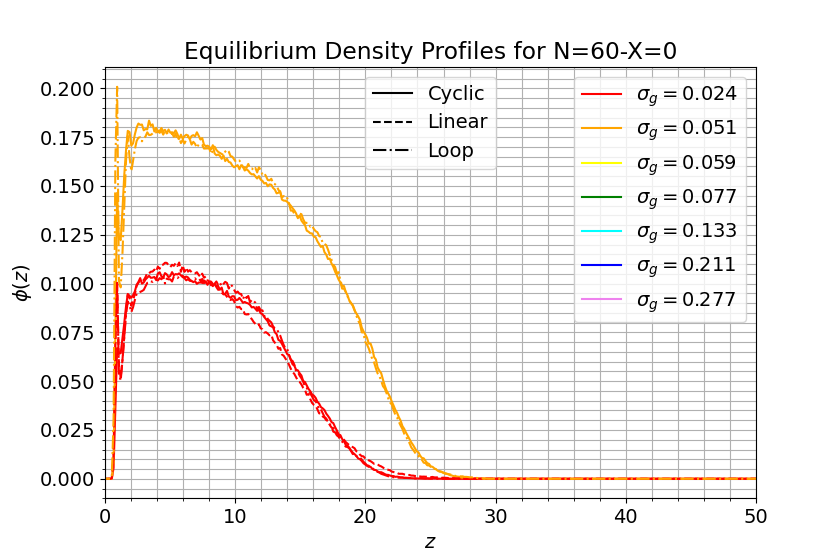

In [24]:
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value = dN, step = 1, description='N')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
mpb = widgets.IntText(value=1,indent=False, description='Monomers/bead')
mpb.style.description_width = '50%'
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
nlines = len(T_Mdirs)
lines = widgets.IntRangeSlider(value=[0,nlines], min=0 , max = nlines)
ui = widgets.Box(children = [N,Kb,mpb,Ring,Linear,Loop,BB,fix,SI,lines], layout = box_layout)

fig,eDPSax = plt.subplots()
def update_eDPS(N,Kb,mpb,Ring,Linear,Loop,BB,fix,SI,lines):
    if fix:
        xlim_current = eDPSax.get_xlim()
        ylim_current = eDPSax.get_ylim()
    eDPSax.clear()
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    eDPSp = [eDPS[i][N,lines[0]:lines[1],Kb,0,0,:,:] for i in range(len(eDPS)) if i not in exclude_list]
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = eDPSax.legend(handles=h, labels=l,loc=9, title="")
    if SI:
        GDlabs = T_Gdirs
        Nv = int(T_Ndirs[N][2:])
        DP = Nv    # degree of polymerization
        CW = Nv * m_bead / 1000# Chain mol wt.
        CWNM = 'N = {0} ({1:.2f} kDa)'.format(Nv,CW)
        axs = pb.myAxs(eDPSp,eDPSax,llabels=(1, GDlabs),xlim=[0,90*L_NM],scale=(L_NM,d_SI),title='Equilibrium Density Profiles for {0}-{1}'.format(CWNM,T_Xdirs[Kb]),xlabel='$z$ (nm)', ylabel=r'$\phi(z)$ $(kg/m^3)$')
        eDPSax.get_legend().set_title(r"$chains/nm^2$")
    else:
        axs = pb.myAxs(eDPSp,eDPSax,llabels=(1, T_Gdirs[lines[0]:lines[1]]),xlim=[0,90],title='Equilibrium Density Profiles for {0}-{1}'.format(T_Ndirs[N],T_Xdirs[Kb]),xlabel='$z$', ylabel=r'$\phi(z)$')
        eDPSax.set_xlim(0,50)
    eDPSax.add_artist(legend1)
#     eDPSax.set_xlim(0,32)
#     eDPSax.set_ylim(0,550)
    if fix:
        eDPSax.set_xlim(xlim_current)
        eDPSax.set_ylim(ylim_current)
#     eDPSax.grid(False)

out = widgets.interactive_output(update_eDPS,{'N':N,'Kb': Kb,'mpb': mpb,'Ring': Ring,'Linear': Linear,'Loop': Loop, 'BB': BB,'fix': fix,'SI': SI,'lines': lines})
display(ui, out)

Output()

Box(children=(IntSlider(value=3, description='N', max=3), IntSlider(value=4, description='M', max=6), IntSlide…

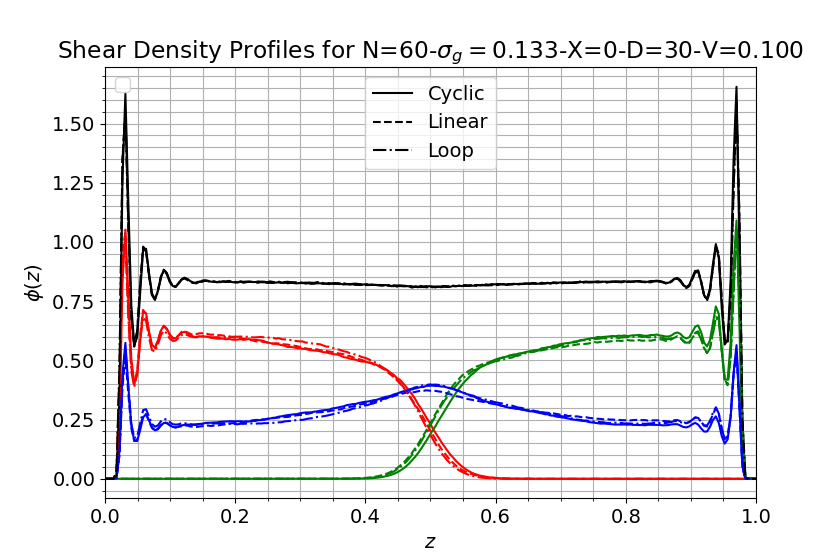

In [25]:
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value = dN, step = 1, description='N')
M=widgets.IntSlider(min=0,max= len(T_Mdirs)-1,value = dM, step = 1, description='M')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
PD=widgets.IntSlider(min=0,max= len(T_PDdirs)-1,value = dPD, step = 1, description='PD')
V=widgets.IntSlider(min=0,max= len(T_Vdirs)-1,value = dV, step = 1, description='V')
mpb = widgets.IntText(value=1,indent=False, description='Monomers/bead')
mpb.style.description_width = '50%'
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
ui = widgets.Box(children = [N,M,Kb,PD,V,mpb,Ring,Linear,Loop,BB,fix,SI], layout = box_layout)

fig,sDPSax = plt.subplots()
def update_sDPS(N, M,Kb, PD, V,mpb,Ring,Linear,Loop,BB,fix,SI):
    if fix:
        xlim_current = sDPSax.get_xlim()
        ylim_current = sDPSax.get_ylim()
    sDPSax.clear()
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = sDPSax.legend(handles=h, labels=l, title="")
    sDPSp = [DPS[i][N,M,Kb,PD,V,:,:] for i in range(len(sDPS)) if i not in exclude_list]
    name = '{0}-{1}-{2}-{3}-{4}'.format(T_Ndirs[N],T_Gdirs[M],T_Xdirs[Kb],T_PDdirs[PD],T_Vdirs[V][:7])
    if SI:
        Mv = float(T_Mdirs[M][2:])
        GD_NM = (Mv/areaLJ)/(L_NM**2)
        GDNM = r'$\rho_g={0:.2f}$ $ch/nm^2$'.format(GD_NM)
        Dv = float(T_PDdirs[PD][2:])
        DNM = 'D={0:.2f} nm'.format(Dv * L_NM)
        Vv = float(T_Vdirs[V][2:])
        VNM = 'V={0:.2f} m/s'.format(Vv * v_SI)
        name = '{0}-{1}-{2}-{3}-{4}'.format(T_Ndirs[N],GDNM,T_Xdirs[Kb],DNM,VNM)
        axs = pb.myAxs(sDPSp,sDPSax,scale=(1,d_SI),xlim=[0,1],title='Shear Density Profiles for {0}'.format(name),xlabel='$z$', ylabel=r'$\phi(z)$ $(kg/m^3)$')
    else:
        
        axs = pb.myAxs(sDPSp,sDPSax,xlim=[0,1],title='Shear Density Profiles for {0}'.format(name),xlabel='$z$', ylabel=r'$\phi(z)$')
#     sDPSax.set(ylim=[0,0.8])
    sDPSax.add_artist(legend1)    
    if fix:
        sDPSax.set_xlim(xlim_current)
        sDPSax.set_ylim(ylim_current)
out =  widgets.interactive_output(update_sDPS,{'N':N,'M':M,'Kb': Kb,'PD':PD,'V':V,'mpb': mpb,'Ring': Ring,'Linear': Linear,'Loop': Loop, 'BB': BB,'fix': fix,'SI': SI})
display(out,ui)

Box(children=(Checkbox(value=False, description='y-shift'), IntSlider(value=0, description='s', max=4), IntSli…

Output()

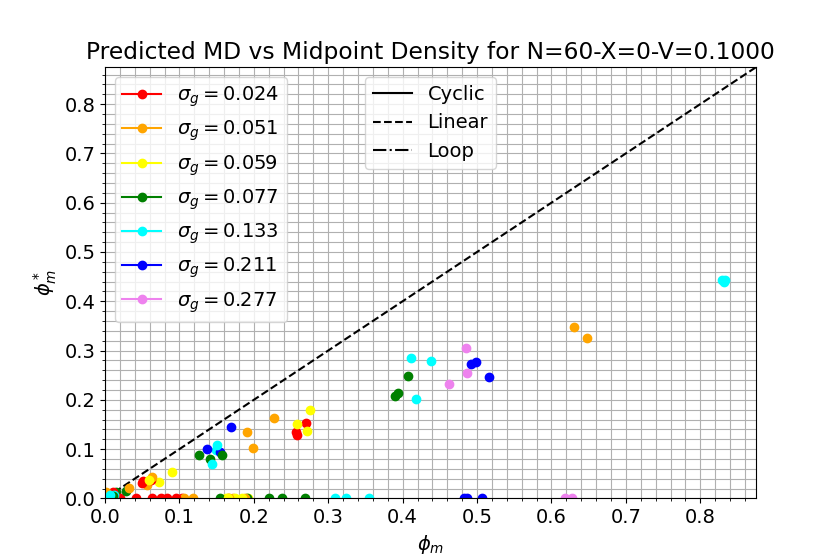

In [27]:
ys = widgets.Checkbox(value=False, description='y-shift')
s=widgets.IntSlider(min=0,max= 4,value = 0, step = 1, description='s')
# sx=widgets.IntSlider(min=0,max= len(Xs)-1,value = 0, step = 1, description='sx')
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value =dN, step = 1, description='N')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
V = widgets.IntSlider(min=0,max= len(T_Vdirs)-1,value = dV, step = 1, description='V')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatSlider(min=0,max= 5,value = 0.5, step =0.1, description='a')
k=widgets.FloatSlider(min=-2.0,max= 2.0,value = 0.333, step = 0.01, description='k')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=False, description='Log')
nlines = len(T_Mdirs)
lines = widgets.IntRangeSlider(value=[0,nlines], min=0 , max = nlines)   
ui = widgets.Box(children = [ys,s,N,Kb,V,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,Log,lines], layout = box_layout)
fig,CPvDlMax = plt.subplots()
def CPvDlM(ys,s,N,Kb,V,errors,power_law_line,a,k,Ring,Linear,Loop,BB,fix,Log,lines):
    Ys = [MDpv,Fnd,Ffd,Fbb,Cbb]
    Xs = [MDv,Fv,Fv,Fv,Cv]
    Cax = CPvDlMax
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = Ys[s]
    Xv = Xs[s]
    siX = 1
    siY = 1
    siY = a
    if power_law_line:
        power_law_0 = (a,k,Xv.l.replace('$',''),Yv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Ndirs[N],T_Xdirs[Kb],T_Vdirs[V][:8])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=9, title="")
    Yd = [Yv.d[i][N,lines[0]:lines[1],Kb,:,V,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][N,lines[0]:lines[1],Kb,:,V,:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [YvX[i] for i in range(len(YvX)) if i not in exclude_list]
    
    axs = pb.myErrorAxs(YvXp,Cax,llabels=(1,T_Gdirs[lines[0]:lines[1]]),xlabel=Xv.l,ylabel=Yv.l,scale=(siX,siY),title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    Lines = Cax.get_lines()
    for Line in Lines:
        Line.set_linestyle('')
    Cax.axline((0,0),(3,3),linestyle='--',color='black')
    xlim = Cax.get_xlim()
    Cax.set_ylim(xlim)

out = widgets.interactive_output(CPvDlM,{'ys':ys,'s':s,'N': N,'Kb': Kb,'V': V,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

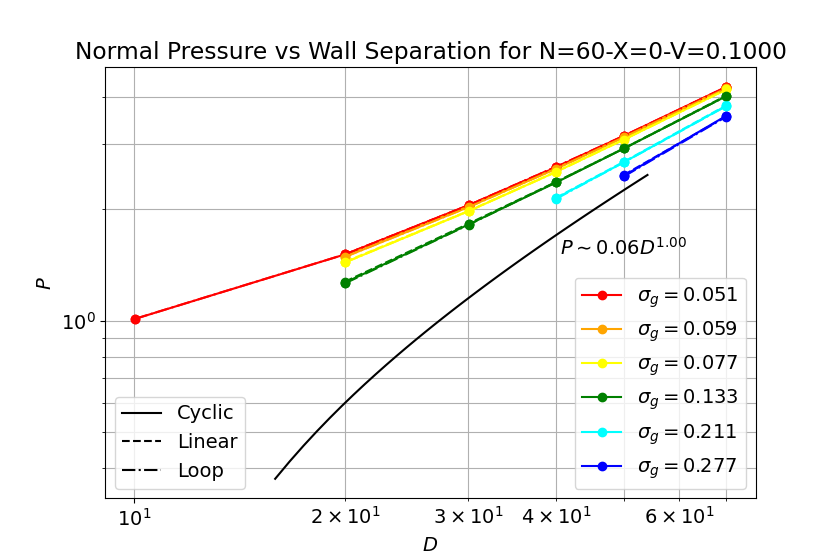

In [28]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=1,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=0,description='Xvar')
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value = dN, step = 1, description='N')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
V = widgets.IntSlider(min=0,max= len(T_Vdirs)-1,value = dV, step = 1, description='V')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=-7,max= 12,value = 4.37e+3, step =0.02, description='a')
k=widgets.FloatSlider(min=-6.0,max= 3.0,value = -2.94, step = 0.01, description='k')
Thesis = widgets.Checkbox(value=True, description='Thesis')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=dLog, description='Log')
nlines = len(T_Mdirs)
lines = widgets.IntRangeSlider(value=[1,7], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,N,Kb,V,errors,power_law_line,a, k,Thesis,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vDlMax = plt.subplots()
def vDlM(xs,ys,sy,sx,N,Kb,V,errors,power_law_line,a, k,Thesis,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vDlMax
#     Ys = [Pv,Ov,Ev,MDv,Lv,O_Ev]
#     Yss = [P_G43v,Osv,Esv,MDsv,Lsv,O_Esv]
#     Xs = [Dv,NDv,Pv,rtPv,Ov]
#     Xss = [D_2Hv,NDv,P_G43v,rtPv,Ov]
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Ndirs[N],T_Xdirs[Kb],T_Vdirs[V][:8])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=3, title="")
    Yd = [Yv.d[i][N,lines[0]:lines[1],Kb,:,V,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][N,lines[0]:lines[1],Kb,:,V,:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,0) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_Gdirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    if Thesis and Yv.scaling != None:
        xbounds = Cax.get_xbound()
        a = Yv.scaling[2][0]
        k = Yv.scaling[2][1]
        x = np.linspace(xbounds[0] + 0.1 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.66 * (xbounds[1] - xbounds[0]),50)
        off  = [(-50,5) if k>0 else (-50,+10)][0]
        if Yv is Pv:
            c = -0.5
            y = c + a * x ** k
            i_mid = round(x.shape[0]/2)

            label=r'$%s \sim %.2f %s^{%.2f}$' % (Yv.l.replace('$',''),a, Xv.l.replace('$',''), k)
            off  = [(30,5) if k>0 else (8,10)][0]
            Cax.annotate(label,xy=(x[i_mid], y[i_mid]), xytext=off,
                           textcoords='offset points')
            line, = Cax.plot(x, y, 'k-')
        else:
            if Yv is Fv:
                x = np.linspace(xbounds[0] + 0.2 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.4 * (xbounds[1] - xbounds[0]),50)
                off  = [(-50,5) if k>0 else (-12,8)][0]
            y = a * x ** k
            i_mid = round(x.shape[0]/2)
            label=r'$%s \sim %s^{%.2f}$' % (Yv.l.replace('$',''), Xv.l.replace('$',''), k)
            Cax.annotate(label,xy=(x[i_mid], y[i_mid]), xytext=off,
                           textcoords='offset points')
            line, = Cax.plot(x, y, 'k-')
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vDlM,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'N': N,'Kb': Kb,'V': V,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Thesis': Thesis,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

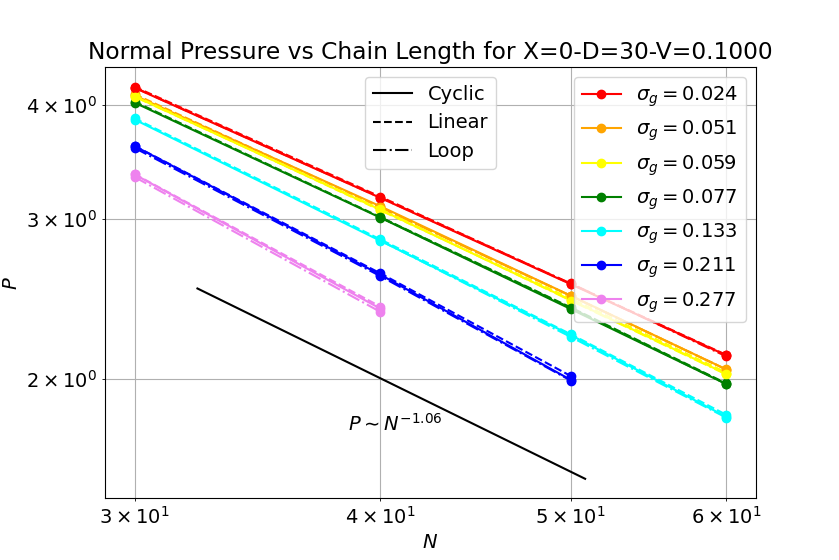

In [29]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=1,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=3,description='Xvar')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
PD = widgets.IntSlider(min=0,max= len(T_PDdirs)-1,value = dPD, step = 1, description='PD')
V = widgets.IntSlider(min=0,max= len(T_Vdirs)-1,value = dV, step = 1, description='V')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=-7,max= 6,value = 75, step =0.02, description='a')
k=widgets.FloatSlider(min=-2.0,max= 6.0,value = 0.333, step = 0.01, description='k')
Thesis = widgets.Checkbox(value=True, description='Thesis')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=dLog, description='Log')
nlines = len(T_Mdirs)
lines = widgets.IntRangeSlider(value=[0,nlines], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,Kb,PD,V,errors,power_law_line,a, k,Thesis,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vNlMax = plt.subplots()
def vNlM(xs,ys,sy,sx,Kb,PD,V,errors,power_law_line,a, k,Thesis,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vNlMax
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Xdirs[Kb],T_PDdirs[PD],T_Vdirs[V][:8])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=9, title="")
    Yd = [Yv.d[i][:,lines[0]:lines[1],Kb,PD,V,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][:,lines[0]:lines[1],Kb,PD,V,:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,1) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_Gdirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    if Thesis and Yv.scaling != None:
        xbounds = Cax.get_xbound()
        a = Yv.scaling[0][0]
        k = Yv.scaling[0][1]
        x = np.linspace(xbounds[0] + 0.1 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.66 * (xbounds[1] - xbounds[0]),50)
        y = a * x ** k
        i_mid = round(x.shape[0]/2)
        label=r'$%s \sim %s^{%.2f}$' % (Yv.l.replace('$',''), Xv.l.replace('$',''), k)
        off  = [(-40,5) if k>0 else (-50,-25)][0]
        Cax.annotate(label,xy=(x[i_mid], y[i_mid]), xytext=off,
                       textcoords='offset points')
        line, = Cax.plot(x, y, 'k-')
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vNlM,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'Kb': Kb,'PD': PD,'V': V,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Thesis': Thesis,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

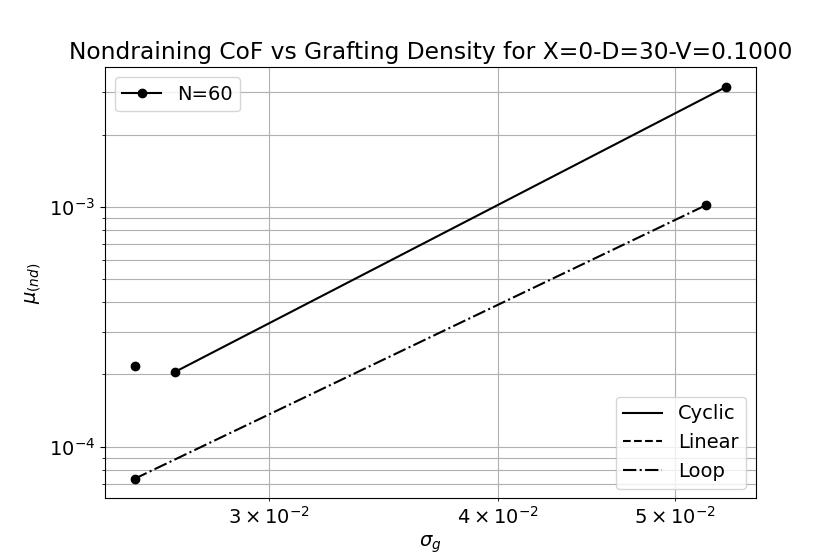

In [30]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=10,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=4,description='Xvar')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
PD = widgets.IntSlider(min=0,max= len(T_PDdirs)-1,value = dPD, step = 1, description='PD')
V = widgets.IntSlider(min=0,max= len(T_Vdirs)-1,value = dV, step = 1, description='V')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=-7,max= 6,value = 75, step =0.02, description='a')
k=widgets.FloatSlider(min=-2.0,max= 3.0,value = 0.333, step = 0.01, description='k')
Thesis = widgets.Checkbox(value=True, description='Thesis')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=True, description='Log')
nlines = len(T_Ndirs)
lines = widgets.IntRangeSlider(value=[3,4], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,Kb,PD,V,errors,power_law_line,a, k,Thesis,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vMlNax = plt.subplots()
def vMlN(xs,ys,sy,sx,Kb,PD,V,errors,power_law_line,a, k,Thesis,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vMlNax
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Xdirs[Kb],T_PDdirs[PD],T_Vdirs[V][:8])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=4, title="")
    Yd = [Yv.d[i][lines[0]:lines[1],:,Kb,PD,V,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][lines[0]:lines[1],:,Kb,PD,V,:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,0) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_Ndirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    if Thesis and Yv.scaling != None:
        xbounds = Cax.get_xbound()
        a = Yv.scaling[1][0]
        k = Yv.scaling[1][1]
        x = np.linspace(xbounds[0] + 0.1 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.66 * (xbounds[1] - xbounds[0]),50)
        if Yv is Pv:
            c = 2
            y = c + a * x ** k
            i_mid = round(x.shape[0]/2)

            label=r'$%s \sim %.2f %s^{%.3f}$' % (Yv.l.replace('$',''),a, Xv.l.replace('$',''), k)
            off  = [(30,5) if k>0 else (8,10)][0]
            Cax.annotate(label,xy=(x[i_mid], y[i_mid]), xytext=off,
                           textcoords='offset points')
            line, = Cax.plot(x, y, 'k-')
        else:
            y = a * x ** k
            i_mid = round(x.shape[0]/2)
            label=r'$%s \sim %s^{%.3f}$' % (Yv.l.replace('$',''), Xv.l.replace('$',''), k)
            off  = [(-50,5) if k>0 else (-40,10)][0]
            Cax.annotate(label,xy=(x[i_mid], y[i_mid]), xytext=off,
                           textcoords='offset points')
            line, = Cax.plot(x, y, 'k-')
        
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vMlN,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'Kb': Kb,'PD': PD,'V': V,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Thesis': Thesis,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

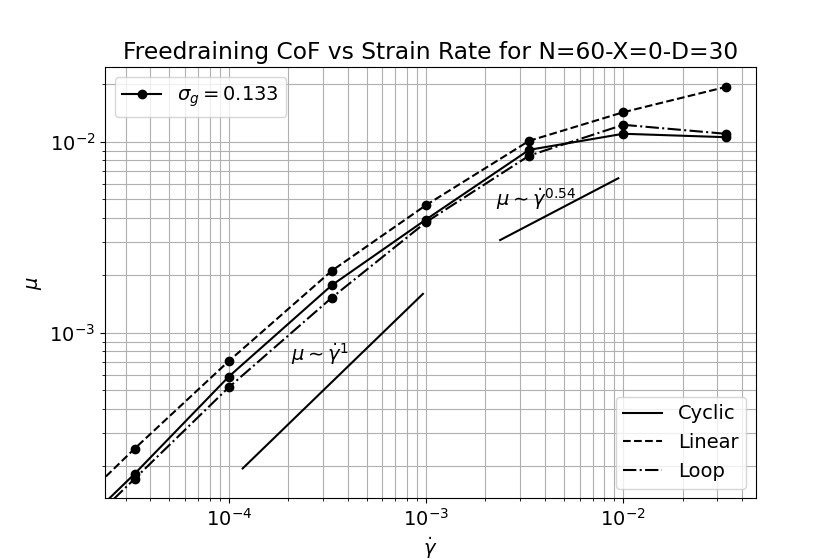

In [31]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=11,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=7,description='Xvar')
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value = dN, step = 1, description='N')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
PD = widgets.IntSlider(min=0,max= len(T_PDdirs)-1,value = dPD, step = 1, description='PD')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=-7,max= 6,value = 1.66, step =0.02, description='a')
k=widgets.FloatSlider(min=-6.0,max= 6.0,value = 1.00, step = 0.01, description='k')
Thesis = widgets.Checkbox(value=True, description='Thesis')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=dLog, description='Log')
nlines = len(T_Mdirs)
lines = widgets.IntRangeSlider(value=[4,5], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,N,Kb,PD,errors,power_law_line,a, k,Thesis,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vVlMax = plt.subplots()
def vVlM(xs,ys,sy,sx,N,Kb,PD,errors,power_law_line,a, k,Thesis,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vVlMax
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Ndirs[N],T_Xdirs[Kb],T_PDdirs[PD])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=4, title="")
    Yd = [Yv.d[i][N,lines[0]:lines[1],Kb,PD,:,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][N,lines[0]:lines[1],Kb,PD,:,:,:] for i in range(len(Xv.d))]
    if Log:
        for i in range(len(Yd)):
            Yd[i][Yd[i]<0] = np.nan
            Yd[i] = np.ma.masked_invalid(Yd[i])
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,0) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_Gdirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    if Thesis and Yv.scaling != None:
        xbounds = Cax.get_xbound()
        aT = Yv.scaling[3][0]
        kT = Yv.scaling[3][1]
        if Yv is Rv:
            x = np.linspace(xbounds[0] + 0.0001 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.002 * (xbounds[1] - xbounds[0]),50)
            off  = [(-90,5) if k>0 else (-70,10)][0]
            x2 = np.linspace(xbounds[0] + 0.002 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.04 * (xbounds[1] - xbounds[0]),50)
            y2 = a * x2 ** k
            i_mid2 = round(x2.shape[0]/2)
            label2=r'$%s \sim %s^{%.2f}$' % (Yv.l.replace('$',''), Xv.l.replace('$',''), k)
            Cax.annotate(label2,xy=(x2[i_mid2], y2[i_mid2]), xytext=(-130,-30),
                           textcoords='offset points')
            line2, = Cax.plot(x2, y2, 'k-')
        elif Yv is Fv:
            x = np.linspace(xbounds[0] + 0.002 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.04 * (xbounds[1] - xbounds[0]),50)
            x2 = np.linspace(xbounds[0] + 0.002 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.04 * (xbounds[1] - xbounds[0]),50)
            y2 = a * x2 ** k
            i_mid2 = round(x2.shape[0]/2)
            label2=r'$%s \sim %s^{%.2f}$' % (Yv.l.replace('$',''), Xv.l.replace('$',''), k)
            Cax.annotate(label2,xy=(x2[i_mid2], y2[i_mid2]), xytext=(-60,-5),
                           textcoords='offset points')
            line2, = Cax.plot(x2, y2, 'k-')
        elif Yv is Cv:
            x = np.linspace(xbounds[0] + 0.002 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.04 * (xbounds[1] - xbounds[0]),50)
            x2 = np.linspace(xbounds[0] + 0.002 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.04 * (xbounds[1] - xbounds[0]),50)
            y2 = a * x2 ** k
            i_mid2 = round(x2.shape[0]/2)
            label2=r'$%s \sim %s^{%.2f}$' % (Yv.l.replace('$',''), Xv.l.replace('$',''), k)
            Cax.annotate(label2,xy=(x2[i_mid2], y2[i_mid2]), xytext=(-60,-5),
                           textcoords='offset points')
            line2, = Cax.plot(x2, y2, 'k-')
        elif Yv is Cfd:
            x = np.linspace(xbounds[0] + 0.05 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.2 * (xbounds[1] - xbounds[0]),50)
            x2 = np.linspace(xbounds[0] + 0.002 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.02 * (xbounds[1] - xbounds[0]),50)
            y2 = a * x2 ** k
            i_mid2 = round(x2.shape[0]/2)
            label2=r'$%s \sim %s^{%.0f}$' % (Yv.l.replace('$',''), Xv.l.replace('$',''), k)
            Cax.annotate(label2,xy=(x2[i_mid2], y2[i_mid2]), xytext=(-60,-15),
                           textcoords='offset points')
            line2, = Cax.plot(x2, y2, 'k-')
            
        else:
            x = np.linspace(xbounds[0] + 0.1 * (xbounds[1] - xbounds[0]), xbounds[0] + 0.66 * (xbounds[1] - xbounds[0]),50)
            off  = [(0,40) if k>0 else (8,10)][0]
        off  = [(-60,-5) if k>0 else (8,10)][0]
        y = aT * x ** kT
        i_mid = round(x.shape[0]/2)
        label=r'$%s \sim %s^{%.2f}$' % (Yv.l.replace('$',''), Xv.l.replace('$',''), kT)
        Cax.annotate(label,xy=(x[i_mid], y[i_mid]), xytext=off,
                       textcoords='offset points')
        line, = Cax.plot(x, y, 'k-')
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vVlM,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'N': N,'Kb': Kb,'PD': PD,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Thesis': Thesis,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

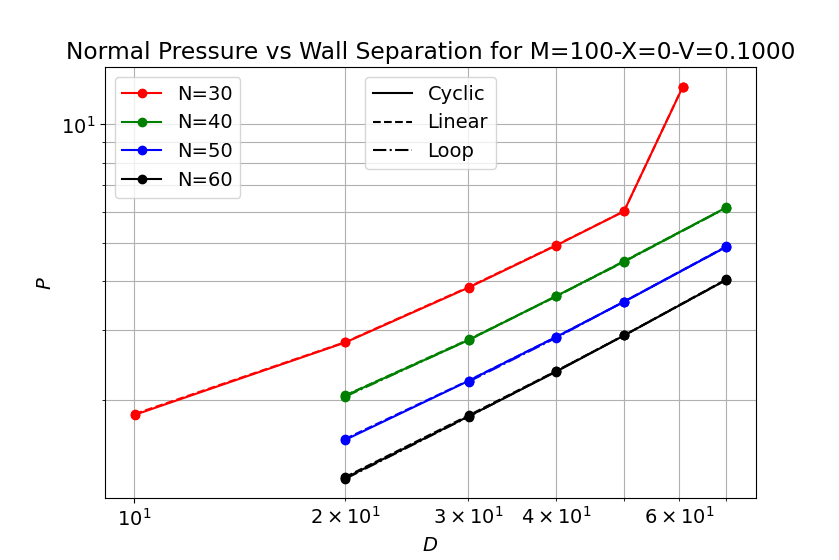

In [32]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=1,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=0,description='Xvar')
M=widgets.IntSlider(min=0,max= len(T_Mdirs)-1,value = dM, step = 1, description='M')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
V = widgets.IntSlider(min=0,max= len(T_Vdirs)-1,value = dV, step = 1, description='V')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=1.5,max= 2.5,value = 75, step =0.02, description='a')
k=widgets.FloatSlider(min=-2.0,max= 2.0,value = 0.333, step = 0.01, description='k')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=dLog, description='Log')
nlines = len(T_Mdirs)
lines = widgets.IntRangeSlider(value=[0,nlines], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,M,Kb,V,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vDlNax = plt.subplots()
def vDlN(xs,ys,sy,sx,M,Kb,V,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vDlNax
#     Ys = [Pv,Ov,Ev,MDv,Lv,O_Ev]
#     Yss = [P_G43v,Osv,Esv,MDsv,Lsv,O_Esv]
#     Xs = [Dv,NDv,Pv,rtPv,Ov]
#     Xss = [D_2Hv,NDv,P_G43v,rtPv,Ov]
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Mdirs[M],T_Xdirs[Kb],T_Vdirs[V][:8])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=9, title="")
    Yd = [Yv.d[i][lines[0]:lines[1],M,Kb,:,V,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][lines[0]:lines[1],M,Kb,:,V,:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,0) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_Ndirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vDlN,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'M': M,'Kb': Kb,'V': V,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

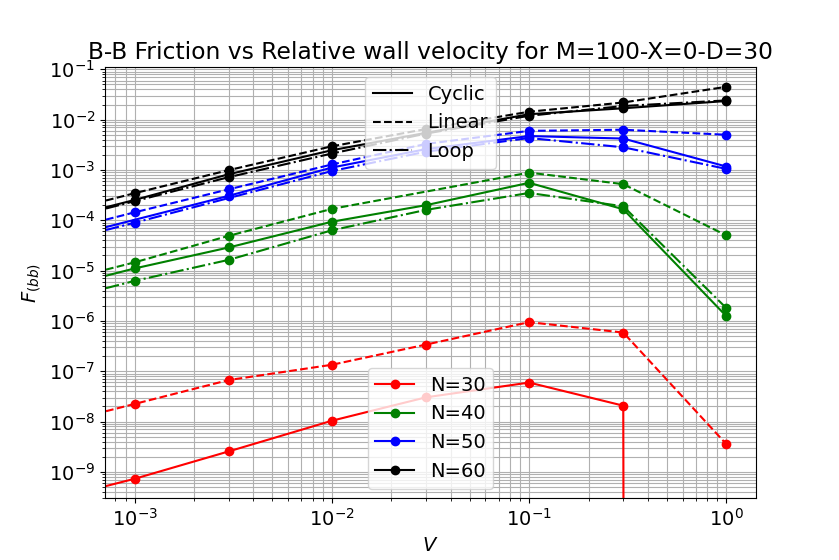

In [33]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=5,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=6,description='Xvar')
M=widgets.IntSlider(min=0,max= len(T_Mdirs)-1,value = dM, step = 1, description='M')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
PD = widgets.IntSlider(min=0,max= len(T_PDdirs)-1,value = dPD, step = 1, description='PD')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=1.5,max= 2.5,value = 75, step =0.02, description='a')
k=widgets.FloatSlider(min=-2.0,max= 2.0,value = 0.333, step = 0.01, description='k')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=dLog, description='Log')
nlines = len(T_Mdirs)
lines = widgets.IntRangeSlider(value=[0,nlines], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,M,Kb,PD,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vVlNax = plt.subplots()
def vVlN(xs,ys,sy,sx,M,Kb,PD,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vVlNax
#     Ys = [Pv,Ov,Ev,MDv,Lv,O_Ev]
#     Yss = [P_G43v,Osv,Esv,MDsv,Lsv,O_Esv]
#     Xs = [Dv,NDv,Pv,rtPv,Ov]
#     Xss = [D_2Hv,NDv,P_G43v,rtPv,Ov]
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Mdirs[M],T_Xdirs[Kb],T_PDdirs[PD])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=9, title="")
    Yd = [Yv.d[i][lines[0]:lines[1],M,Kb,PD,:,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][lines[0]:lines[1],M,Kb,PD,:,:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,0) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_Ndirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vVlN,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'M': M,'Kb': Kb,'PD': PD,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

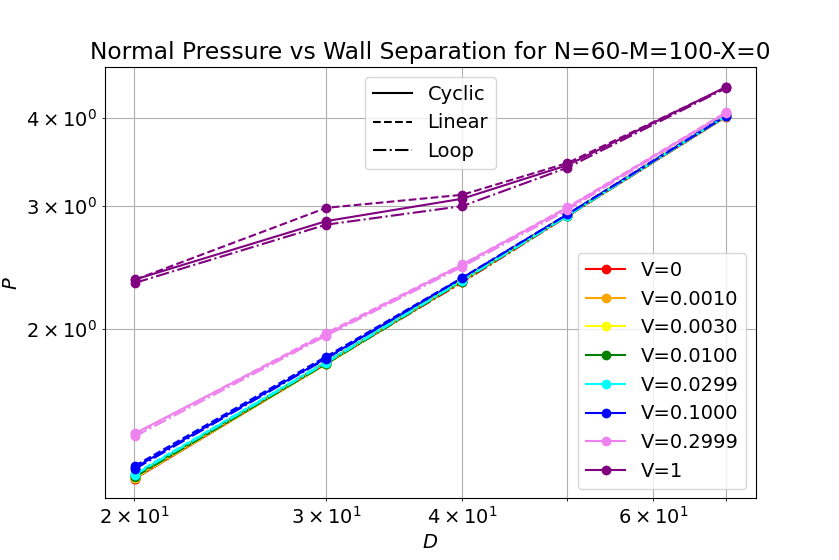

In [34]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=1,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=0,description='Xvar')
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value = dN, step = 1, description='N')
M=widgets.IntSlider(min=0,max= len(T_Mdirs)-1,value = dM, step = 1, description='M')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=1.5,max= 2.5,value = 75, step =0.02, description='a')
k=widgets.FloatSlider(min=-2.0,max= 2.0,value = 0.333, step = 0.01, description='k')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=dLog, description='Log')
nlines = len(T_Vdirs)
lines = widgets.IntRangeSlider(value=[0,nlines], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,N,M,Kb,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vDlVax = plt.subplots()
def vDlV(xs,ys,sy,sx,N,M,Kb,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vDlVax
#     Ys = [Pv,Ov,Ev,MDv,Lv,O_Ev]
#     Yss = [P_G43v,Osv,Esv,MDsv,Lsv,O_Esv]
#     Xs = [Dv,NDv,Pv,rtPv,Ov]
#     Xss = [D_2Hv,NDv,P_G43v,rtPv,Ov]
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Ndirs[N],T_Mdirs[M],T_Xdirs[Kb])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=9, title="")
    Yd = [Yv.d[i][N,M,Kb,:,lines[0]:lines[1],:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][N,M,Kb,:,lines[0]:lines[1],:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,1) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_Vdirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vDlV,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'N': N,'M': M,'Kb': Kb,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

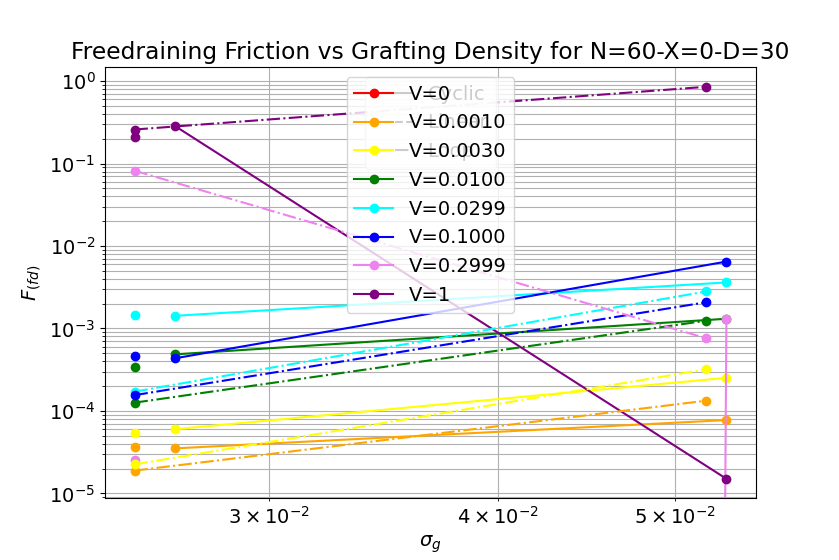

In [35]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=7,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=4,description='Xvar')
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value = dN, step = 1, description='N')
PD = widgets.IntSlider(min=0,max= len(T_PDdirs)-1,value = dPD, step = 1, description='PD')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=1.5,max= 2.5,value = 75, step =0.02, description='a')
k=widgets.FloatSlider(min=-2.0,max= 2.0,value = 0.333, step = 0.01, description='k')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=dLog, description='Log')
nlines = len(T_Vdirs)
lines = widgets.IntRangeSlider(value=[0,nlines], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,N,Kb,PD,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vMlVax = plt.subplots()
def vMlV(xs,ys,sy,sx,N,Kb,PD,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vMlVax
#     Ys = [Pv,Ov,Ev,MDv,Lv,O_Ev]
#     Yss = [P_G43v,Osv,Esv,MDsv,Lsv,O_Esv]
#     Xs = [Dv,NDv,Pv,rtPv,Ov]
#     Xss = [D_2Hv,NDv,P_G43v,rtPv,Ov]
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Ndirs[N],T_Xdirs[Kb],T_PDdirs[PD])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=9, title="")
    Yd = [Yv.d[i][N,:,Kb,PD,lines[0]:lines[1],:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][N,:,Kb,PD,lines[0]:lines[1],:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,1) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_Vdirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vMlV,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'N': N,'Kb': Kb,'PD':PD,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Box(children=(Checkbox(value=False, description='x-shift'), Checkbox(value=False, description='y-shift'), Drop…

Output()

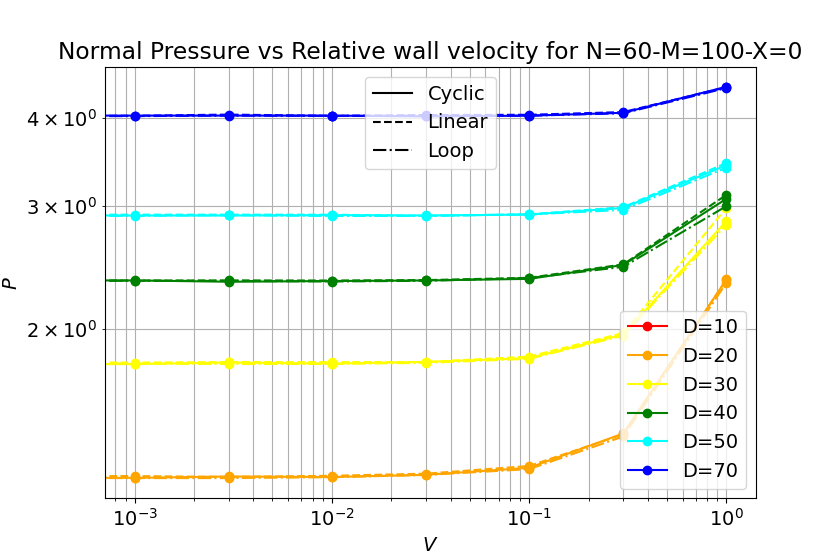

In [36]:
ys = widgets.Checkbox(value=False, description='y-shift')
xs = widgets.Checkbox(value=False, description='x-shift')
sy = widgets.Dropdown(options=Yopt,value=1,description='Yvar')
sx = widgets.Dropdown(options=Xopt,value=6,description='Xvar')
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value = dN, step = 1, description='N')
M=widgets.IntSlider(min=0,max= len(T_Mdirs)-1,value = dM, step = 1, description='M')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatLogSlider(min=1.5,max= 2.5,value = 75, step =0.02, description='a')
k=widgets.FloatSlider(min=-2.0,max= 2.0,value = 0.333, step = 0.01, description='k')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=dLog, description='Log')
nlines = len(T_PDdirs)
lines = widgets.IntRangeSlider(value=[0,nlines], min=0 , max = nlines)   
ui = widgets.Box(children = [xs,ys,sy,sx,N,M,Kb,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines], layout = box_layout)
fig,vVlDax = plt.subplots()
def vVlD(xs,ys,sy,sx,N,M,Kb,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,SI,Log,lines):
    Cax = vVlDax
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = [Yss[sy] if ys else Ys[sy]][0]
    Xv = [Xss[sx] if xs else Xs[sx]][0]
    siX = [Xv.si if SI else 1][0]
    siY = [Yv.si if SI else 1][0]
    lX = [Xv.sil if SI else Xv.l][0]
    lY = [Yv.sil if SI else Yv.l][0]
    if power_law_line:
        power_law_0 = (a,k,Yv.l.replace('$',''),Xv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Ndirs[N],T_Mdirs[M],T_Xdirs[Kb])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=9, title="")
    Yd = [Yv.d[i][N,M,Kb,lines[0]:lines[1],:,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][N,M,Kb,lines[0]:lines[1],:,:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [np.swapaxes(YvX[i],0,0) for i in range(len(YvX)) if i not in exclude_list]
    axs = pb.myErrorAxs(YvXp,Cax,scale=(siX,siY),llabels=(1,T_PDdirs[lines[0]:lines[1]]),xlabel=lX,ylabel=lY,title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    
out = widgets.interactive_output(vVlD,{'xs':xs,'ys':ys,'sy':sy,'sx':sx,'N': N,'M': M,'Kb': Kb,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'SI': SI,'Log': Log,'lines':lines})
display(ui,out)

Output()

Box(children=(IntSlider(value=3, description='N', max=3), IntSlider(value=4, description='M', max=6), IntSlide…

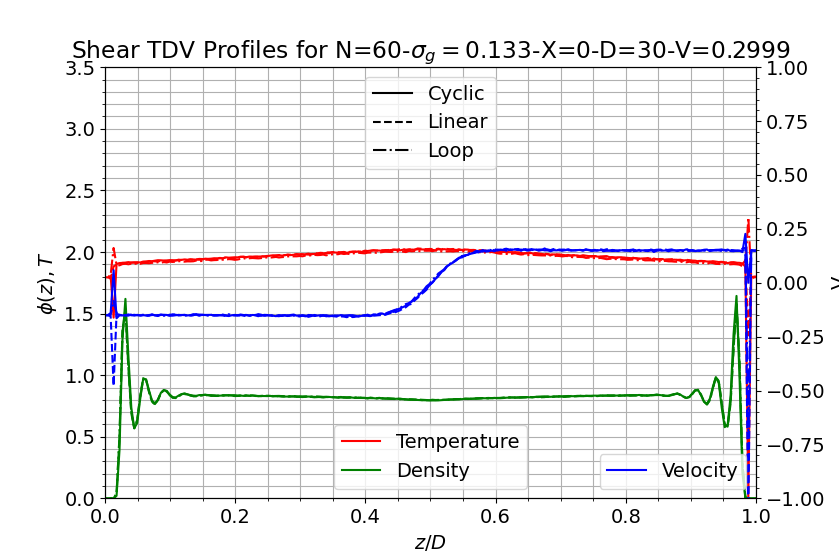

In [37]:
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value =dN, step = 1, description='N')
M=widgets.IntSlider(min=0,max= len(T_Mdirs)-1,value = dM, step = 1, description='M')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
PD=widgets.IntSlider(min=0,max= len(T_PDdirs)-1,value = dPD, step = 1, description='PD')
V=widgets.IntSlider(min=0,max= len(T_Vdirs0)-1,value = dV, step = 1, description='V')
mpb = widgets.IntText(value=1,indent=False, description='Monomers/bead')
mpb.style.description_width = '50%'
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
ui = widgets.Box(children = [N,M,PD,V,mpb,Ring,Linear,Loop,BB,fix,SI], layout = box_layout)


fig, TDVax = plt.subplots()
def update_TDV(N,M,Kb,PD,V,mpb,Ring,Linear,Loop,BB,fix,SI):
    if fix:
        xlim_current = TDVax.get_xlim()
        ylim_current = TDVax.get_ylim()
    TDVax.clear()
    
    title = 'Shear TDV Profiles for {0}-{1}-{2}-{3}-{4:}'.format(T_Ndirs[N], T_Gdirs[M],
                                                        T_Xdirs[Kb],T_PDdirs[PD],T_Vdirs0[V][:8])
    if SI:
        Nv = int(T_Ndirs[N][2:])
        DP = Nv    # degree of polymerization
        CW = Nv *  m_bead / 1000# Chain mol wt.
        CWNM = 'DoP = {0} ({1:.2f} kDa)'.format(DP,CW)
        Mv = float(T_Mdirs[M][2:])
        GD_NM = (Mv/areaLJ)/(L_NM**2)
        GDNM = r'$\rho_g={0:.3f}$ $ch/nm^2$'.format(GD_NM)
        Dv = float(T_PDdirs[PD][2:])
        DNM = 'D={0:.2f} nm'.format(Dv * L_NM)
        Vv = float(T_Vdirs[V][2:])
        VNM = 'V={0:.2f} m/s'.format(Vv * v_SI)
        title = '{0}-{1}-{2}-{3}-{4}'.format(CWNM, GDNM,
                                                        T_Xdirs[Kb],DNM,VNM)
        
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = TDVax.legend(handles=h, labels=l,loc=9, title="")
    axs = pb.myAxs([TDV[i][N,M,Kb,PD,V,:,:] for i in range(len(TDV)) if i not in exclude_list], TDVax, llabels=(2, ['Temperature', 'Density', 'Velocity']), axis2=[0, 0, 1],
                         xlim=[0, 1],title=title,
                         xlabel='$z/D$', ylabel=r'$\phi(z), T$', y2label='V')
    axs[0].set_ylim(0,3.5)
    axs[1].set_ylim(-1,1)
    TDVax.add_artist(legend1)    
    #axs[1].get_yaxis().set_visible(False)
    if fix:
        TDVax.set_xlim(xlim_current)
        TDVax.set_ylim(ylim_current)
    return None
out =  widgets.interactive_output(update_TDV,{'N':N,'M':M,'Kb': Kb,'PD':PD,'V':V,'mpb': mpb,'Ring': Ring,'Linear': Linear,'Loop': Loop, 'BB': BB,'fix': fix,'SI': SI})
display(out,ui)

Box(children=(Checkbox(value=False, description='y-shift'), IntSlider(value=0, description='s', max=4), IntSli…

Output()

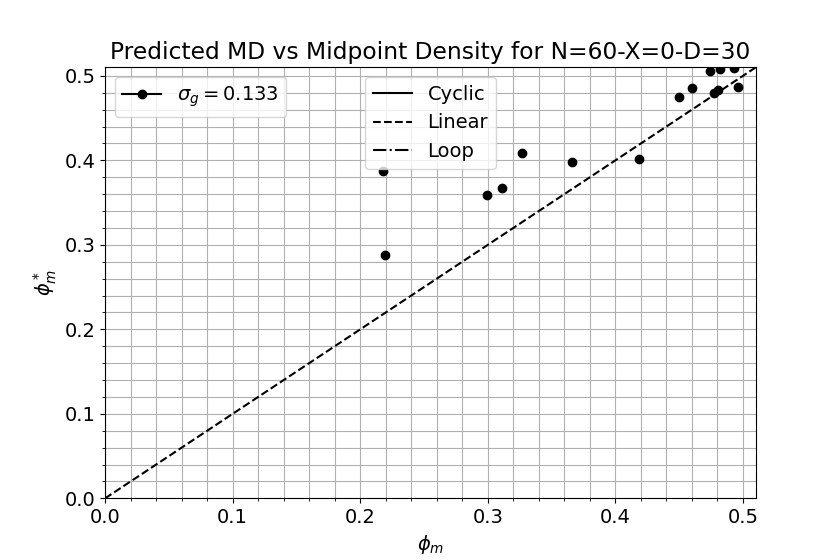

In [38]:
ys = widgets.Checkbox(value=False, description='y-shift')
s=widgets.IntSlider(min=0,max=4,value = 0, step = 1, description='s')
# sx=widgets.IntSlider(min=0,max= len(Xs)-1,value = 0, step = 1, description='sx')
N=widgets.IntSlider(min=0,max= len(T_Ndirs)-1,value =dN, step = 1, description='N')
Kb=widgets.IntSlider(min=0,max= len(T_Xdirs)-1,value = dX, step = 1, description='Kb')
PD = widgets.IntSlider(min=0,max= len(T_PDdirs)-1,value = dPD, step = 1, description='PD')
errors = widgets.Checkbox(value=False, description='errors')
power_law_line = widgets.Checkbox(value=False, description='power_law')
a=widgets.FloatSlider(min=0,max= 5,value = 1, step =0.1, description='a')
k=widgets.FloatSlider(min=-2.0,max= 2.0,value = 0.333, step = 0.01, description='k')
Ring = widgets.Checkbox(value=dRing, description='Ring')
Linear = widgets.Checkbox(value=dLinear, description='Linear')
Loop = widgets.Checkbox(value=dLoop, description='Loop')
BB = widgets.Checkbox(value=dBB, description='BB')
fix = widgets.Checkbox(value=False, description='fix')
SI = widgets.Checkbox(value=dSI, description='SI')
Log = widgets.Checkbox(value=False, description='Log')
nlines = len(T_Mdirs)
lines = widgets.IntRangeSlider(value=[4,5], min=0 , max = nlines)   
ui = widgets.Box(children = [ys,s,N,Kb,PD,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,Log,lines], layout = box_layout)
fig,CPvVlMax = plt.subplots()
def CPvVlM(ys,s,N,Kb,PD,errors,power_law_line,a, k,Ring,Linear,Loop,BB,fix,Log,lines):
    Ys = [MDpv,Ffd,Fnd,Fbb,Cbb]
    Xs = [MDv,Fv,Fv,Fv,Cv]
    Cax = CPvVlMax
    if fix:
        xlim_current = Cax.get_xlim()
        ylim_current = Cax.get_ylim()
    Cax.clear()
    Yv = Ys[s]
    Xv = Xs[s]
    siX = 1
    siY = 1
    siY = a
    if power_law_line:
        power_law_0 = (a,k,Xv.l.replace('$',''),Yv.l.replace('$',''))
    else:
        power_law_0 = (0,0,0,0)
    title = r'{0} vs {1} for {2}-{3}-{4}'.format(Yv.n,Xv.n,T_Ndirs[N],T_Xdirs[Kb],T_PDdirs[PD])
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    legend1 = Cax.legend(handles=h, labels=l,loc=9, title="")
    Yd = [Yv.d[i][N,lines[0]:lines[1],Kb,PD,:,:,:] for i in range(len(Yv.d))]
    Xd = [Xv.d[i][N,lines[0]:lines[1],Kb,PD,:,:,:] for i in range(len(Xv.d))]
    YvX = [np.ma.concatenate((Xd[i],Yd[i]),axis=-2) for i in range(len(Xd))]
    exclude_list = make_exclude_list(Ring,Linear,Loop,BB)
    YvXp = [YvX[i] for i in range(len(YvX)) if i not in exclude_list]
    
    axs = pb.myErrorAxs(YvXp,Cax,llabels=(1,T_Gdirs[lines[0]:lines[1]]),xlabel=Xv.l,ylabel=Yv.l,scale=(siX,siY),title=title,log=(Log,Log),bars=errors, power_law=power_law_0)
    h = make_handles(Ring,Linear,Loop,BB)
    l = make_labels(Ring,Linear,Loop,BB)
    Cax.add_artist(legend1)
    if fix:
        Cax.set_xlim(xlim_current)
        Cax.set_ylim(ylim_current)
    Lines = Cax.get_lines()
    for Line in Lines:
        Line.set_linestyle('')
    Cax.axline((0,0),(3,3),linestyle='--',color='black')
    xlim = Cax.get_xlim()
    Cax.set_ylim(xlim)

out = widgets.interactive_output(CPvVlM,{'ys':ys,'s':s,'N': N,'Kb': Kb,'PD': PD,'errors':errors, 'power_law_line': power_law_line,'a': a,'k':k,'Ring': Ring,'Linear': Linear,'Loop': Loop,'BB': BB,'fix': fix,'Log': Log,'lines':lines})
display(ui,out)

In [39]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')